In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!unzip hyper-kvasir-segmented-images.zip 


Archive:  hyper-kvasir-segmented-images.zip
  inflating: segmented-images/bounding-boxes.json  
   creating: segmented-images/images/
  inflating: segmented-images/images/0004a718-546c-41c2-9c69-c4685093a039.jpg  
  inflating: segmented-images/images/0017b7c7-90f8-4de2-8723-1d87e5c58317.jpg  
  inflating: segmented-images/images/0048d8c5-b59d-461c-9834-f44a727e191d.jpg  
  inflating: segmented-images/images/00f98835-8fd8-43fe-960d-f4a1159c30f1.jpg  
  inflating: segmented-images/images/01503109-d81f-404e-a919-31de1aceb6b9.jpg  
  inflating: segmented-images/images/0198bc50-169e-456c-a56b-970a7f7d23b7.jpg  
  inflating: segmented-images/images/01c95ee8-79cc-46f4-a6a0-834d8a6045d4.jpg  
  inflating: segmented-images/images/01dbf397-c0fc-40e7-9b04-86de70781c9a.jpg  
  inflating: segmented-images/images/01dcc13a-85ab-4d6e-b42b-5d631e076ac2.jpg  
  inflating: segmented-images/images/01e6cfd7-bdb6-4929-9fc0-9a7dd2d3c7f7.jpg  
  inflating: segmented-images/images/026e9707-e74d-434f-98f4-6ceb2

In [3]:
#must run this
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
from PIL import Image
from keras import backend, optimizers

In [4]:
image_directory = 'segmented-images/images/'
mask_directory = 'segmented-images/masks/'

In [5]:
SIZE = 256
image_dataset = []  
mask_dataset = [] 

In [6]:
images = os.listdir(image_directory)
for i, image_name in enumerate(sorted(images)):    
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [7]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(sorted(masks)):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [8]:

image_dataset = np.array(image_dataset)/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 2)

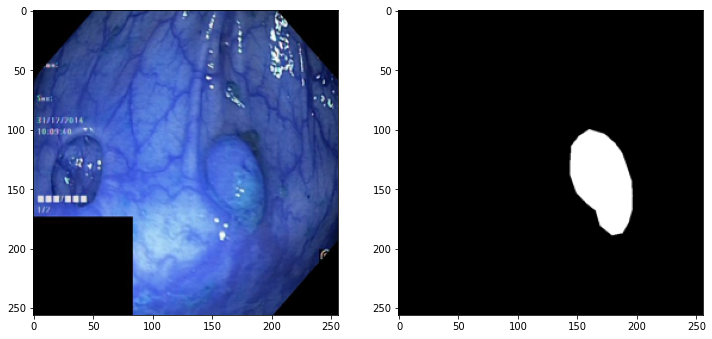

In [10]:
#Sanity check
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [11]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1 
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS) 
batch_size = 8

In [12]:

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)



def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)



In [ ]:
##MODEL CODE STARTS HERE. BELOW ARE MANY FUNCTIONS, CLASS of BLOCKS WILL BE USED WHILE COMPILING THE MODEL

In [ ]:
#These are for Attresunet. These will change for other models

In [ ]:
kernel_initializer="he_normal"


def repeat_elem(tensor, rep):
    

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm):
    

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same', kernel_initializer=kernel_initializer)(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same', kernel_initializer=kernel_initializer)(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same', kernel_initializer=kernel_initializer)(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)   
    return res_path

def gating_signal(input, out_size, batch_norm):

    x = layers.Conv2D(out_size, (1, 1), padding='same', kernel_initializer=kernel_initializer)(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)


    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer=kernel_initializer)(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same', kernel_initializer=kernel_initializer)(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same', kernel_initializer=kernel_initializer)(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same', kernel_initializer=kernel_initializer)(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [ ]:

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0, batch_norm=True):
  
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1), kernel_initializer=kernel_initializer)(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [13]:
!pip install focal-loss
from focal_loss import BinaryFocalLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 0.01), loss=BinaryFocalLoss(gamma=2), metrics=['accuracy', jacard_coef, dice_coef, jacard_coef_loss, dice_coef_loss])


#att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy',jacard_coef])

print(att_res_unet_model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model_path = "/content/drive/MyDrive/d5-3_21nov.hdf5"

att_res_unet_model = tf.keras.models.load_model(model_path, compile=False)

att_res_unet_model.compile(optimizer=Adam(lr = 0.01), loss=BinaryFocalLoss(gamma=2), metrics=['accuracy', dice_coef, dice_coef_loss])

att_res_unet_model.summary()

results = att_res_unet_model.evaluate(X_test, y_test, batch_size=8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler
epochs=85

def scheduler(epoch,lr):
  if epoch <=45:
  #  return lr
  # elif 15 < epoch <= 35:
  #   return 0.001
  # elif 35 < epoch <= 60:
    return 0.01
  else:
    return 0.01


lr =0.01
for i in range(epochs):
  lr = scheduler(i,lr)
  print(i, lr)




0 0.01
1 0.01
2 0.01
3 0.01
4 0.01
5 0.01
6 0.01
7 0.01
8 0.01
9 0.01
10 0.01
11 0.01
12 0.01
13 0.01
14 0.01
15 0.01
16 0.01
17 0.01
18 0.01
19 0.01
20 0.01
21 0.01
22 0.01
23 0.01
24 0.01
25 0.01
26 0.01
27 0.01
28 0.01
29 0.01
30 0.01
31 0.01
32 0.01
33 0.01
34 0.01
35 0.01
36 0.01
37 0.01
38 0.01
39 0.01
40 0.01
41 0.01
42 0.01
43 0.01
44 0.01
45 0.01
46 0.01
47 0.01
48 0.01
49 0.01
50 0.01
51 0.01
52 0.01
53 0.01
54 0.01
55 0.01
56 0.01
57 0.01
58 0.01
59 0.01
60 0.01
61 0.01
62 0.01
63 0.01
64 0.01
65 0.01
66 0.01
67 0.01
68 0.01
69 0.01
70 0.01
71 0.01
72 0.01
73 0.01
74 0.01
75 0.01
76 0.01
77 0.01
78 0.01
79 0.01
80 0.01
81 0.01
82 0.01
83 0.01
84 0.01


In [32]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/d6_2_21novcheck.hdf5', monitor='val_dice_coef_loss', verbose=1, save_best_only=True)
lr_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [checkpointer,lr_rate]

Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9864 - dice_coef: 0.8943 - dice_coef_loss: -0.8943
Epoch 00001: val_dice_coef_loss improved from inf to -0.63499, saving model to /content/drive/MyDrive/d6_2_21novcheck.hdf5
75/75 [==============================] - 95s 1s/step - loss: 0.0032 - accuracy: 0.9864 - dice_coef: 0.8943 - dice_coef_loss: -0.8943 - val_loss: 0.1452 - val_accuracy: 0.9148 - val_dice_coef: 0.6350 - val_dice_coef_loss: -0.6350
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9722 - dice_coef: 0.7675 - dice_coef_loss: -0.7675
Epoch 00002: val_dice_coef_loss did not improve from -0.63499
75/75 [==============================] - 86s 1s/step - loss: 0.0144 - accuracy: 0.9722 - dice_coef: 0.7675 - dice_coef_loss: -0.7675 - val_loss: 0.4440 - val_accuracy: 0.7963 - val_dice_coef: 0.5617 - val_dice_coef_loss: -0.5617
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.0050 - 

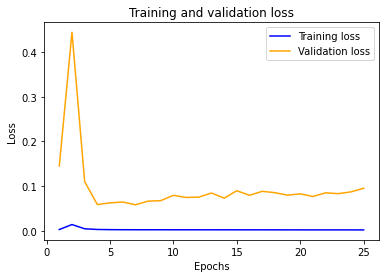

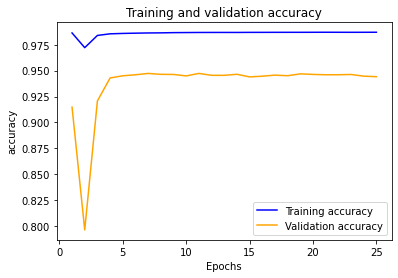

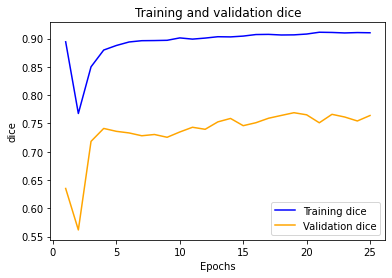

In [33]:

att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = 12,
                    validation_data=(X_test, y_test), 
                    shuffle=True,
                    epochs=125,
                    callbacks=callbacks_list,
                    )

att_res_unet_model.save('/content/drive/MyDrive/d6_2_21nov.hdf5') 


import pandas as pd 
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('/content/drive/MyDrive/d6_2_21nov_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f) 


history = att_res_unet_history

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='blue', label='Training loss')
plt.plot(epochs, val_loss, color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='blue', label='Training accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.plot(epochs, dice, color='blue', label='Training dice')
plt.plot(epochs, val_dice, color='orange', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('dice')
plt.legend()
plt.show()



In [15]:
model = att_res_unet_model

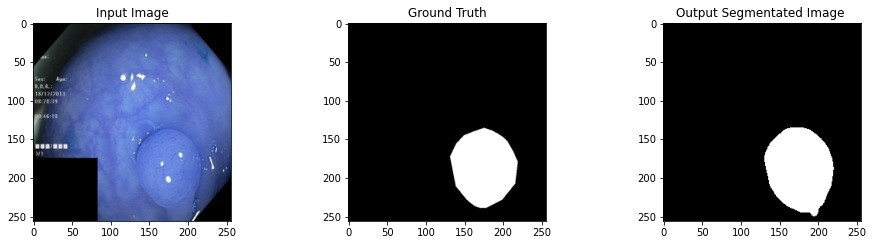

iou=  0.90526
dice=  0.9334357
accuracy=  0.9795685
precision: 0.91106147
recall: 0.99128073
f1 0.9494796991348267


In [16]:

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Input Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Output Segmentated Image ')
plt.imshow(prediction, cmap='gray')
plt.show()


from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
iou = IOU_keras.result().numpy()

y_true = ground_truth
y_pred = prediction

m = tf.keras.metrics.Precision()
m.update_state(y_true, y_pred)
precision = m.result().numpy()

m2 = tf.keras.metrics.Recall()
m2.update_state(y_true, y_pred)
recall = m2.result().numpy()

m3 = tf.keras.metrics.Accuracy()
m3.update_state(y_true, y_pred)
accuracy = m3.result().numpy()

f1= 2*((precision*recall)/(precision+recall))


ground_truth = ground_truth.astype('float32')
prediction = prediction.astype('float32')
dice=dice_coef(ground_truth, prediction).numpy()

print("iou= ", iou)
print("dice= ",dice)
print("accuracy= ",accuracy)
print('precision:',precision)
print('recall:', recall)
print('f1', f1)


In [17]:

import pandas as pd

IoU_values = []
dice_values = []
precision_values = []
recall_values = []
f1_values = []
accuracy_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(231)
    plt.title('Input Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Ground Truth')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Output Segmented Image')
    plt.imshow(prediction, cmap='gray')
    plt.show()
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    ground_truth1 = ground_truth.astype('float32')
    prediction1 = prediction.astype('float32')
    dice = dice_coef(ground_truth1, prediction1).numpy()
    dice_values.append(dice)



    y_true = ground_truth
    y_pred = prediction

    m = tf.keras.metrics.Precision()
    m.update_state(y_true, y_pred)
    precision = m.result().numpy()
    precision_values.append(precision)

    m2 = tf.keras.metrics.Recall()
    m2.update_state(y_true, y_pred)
    recall = m2.result().numpy()
    recall_values.append(recall)

    m3 = tf.keras.metrics.Accuracy()
    m3.update_state(y_true, y_pred)
    accuracy = m3.result().numpy()
    accuracy_values.append(accuracy)

    f1= 2*((precision*recall)/(precision+recall))
    f1_values.append(f1)

   

    print("iou= ", IoU)
    print("dice= ",dice)
    print("accuracy= ",accuracy)
    print('precision:',precision)
    print('recall:', recall)
    print('f1', f1)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values

df2 = pd.DataFrame(dice_values, columns=["dice"])
df2 = df2[df2.dice != 1.0]    
mean_dice = df2.mean().values

df3 = pd.DataFrame(accuracy_values, columns=["accuracy"])
df3 = df3[df3.accuracy != 1.0]    
mean_accuracy = df3.mean().values

df4 = pd.DataFrame(precision_values, columns=["precision"])
df4 = df4[df4.precision != 1.0]    
mean_precision = df4.mean().values

df5 = pd.DataFrame(recall_values, columns=["recall"])
df5 = df5[df5.recall != 1.0]    
mean_recall = df5.mean().values

df6 = pd.DataFrame(f1_values, columns=["f1"])
df6 = df6[df6.f1 != 1.0]    
mean_f1 = df6.mean().values

print("Mean IoU on 10% test is: ", mean_IoU)    
print("Mean dice  on 10% test is: ", mean_dice)  
print("Mean accuracy  on 10% test is: ", mean_accuracy)  
print("Mean precision on 10% test is: ", mean_precision)    
print("Mean recall  on 10% test is: ", mean_recall)  
print("Mean f1 on 10% test  is: ", mean_f1) 

Output hidden; open in https://colab.research.google.com to view.

In [22]:

!unzip unseen.zip

Archive:  unseen.zip
   creating: unseen/images/
  inflating: unseen/images/003ab8b5-cf6d-442a-849d-80ddf0d1edaf.jpg  
  inflating: unseen/images/003f46f1-e447-486a-aeb7-6bf8b45a2184.jpg  
  inflating: unseen/images/00be7d4a-d643-4075-9ea3-e5bff2cd9a5c.jpg  
  inflating: unseen/images/00c7089c-caf9-4c1b-850f-bedbb11668fc.jpg  
  inflating: unseen/images/01deb8d0-4bc5-4092-9a76-9f5c2f74f0df.jpg  
  inflating: unseen/images/02ae2444-eddf-4fec-8b87-babc265d1553.jpg  
  inflating: unseen/images/02c9cc1e-349a-4689-bfb4-b7df1f44ca53.jpg  
  inflating: unseen/images/02d64f66-07e3-4e32-8ecd-5fec7e8acdba.jpg  
  inflating: unseen/images/02e05e0f-5335-4d25-b41b-8f3181fa8941.jpg  
  inflating: unseen/images/03a74938-0db3-4544-9a1a-e74121c47a9a.jpg  
  inflating: unseen/images/03b5d73c-d096-4d5c-af50-39c218425fcd.jpg  
  inflating: unseen/images/03b7f01a-8122-4cdf-8ddc-2b052f4b4099.jpg  
  inflating: unseen/images/03e15c74-4234-4074-bd5b-b4b81834d3d6.jpg  
  inflating: unseen/images/04c3a34e-a160-

In [18]:

test_seg_image = 'unseen/images/'
test_seg_mask = 'unseen/masks/'

In [19]:

SIZE = 256
test_image_dataset = []  
test_mask_dataset = []


In [20]:

images = os.listdir(test_seg_image)
for i, image_name in enumerate(sorted(images)):    
    if (image_name.split('.')[1] == 'jpg'):
      image = cv2.imread(test_seg_image+image_name, 1)
      image = Image.fromarray(image)
      image = image.resize((SIZE, SIZE))
      test_image_dataset.append(np.array(image))

In [21]:
filenames = []
files = os.listdir(test_seg_image)
for i, image_name in enumerate(sorted(files)):    
    if (image_name.split('.')[1] == 'jpg'):
      filenames.append(image_name)
      print(image_name)
      


003ab8b5-cf6d-442a-849d-80ddf0d1edaf.jpg
003f46f1-e447-486a-aeb7-6bf8b45a2184.jpg
00be7d4a-d643-4075-9ea3-e5bff2cd9a5c.jpg
00c7089c-caf9-4c1b-850f-bedbb11668fc.jpg
01deb8d0-4bc5-4092-9a76-9f5c2f74f0df.jpg
02ae2444-eddf-4fec-8b87-babc265d1553.jpg
02c9cc1e-349a-4689-bfb4-b7df1f44ca53.jpg
02d64f66-07e3-4e32-8ecd-5fec7e8acdba.jpg
02e05e0f-5335-4d25-b41b-8f3181fa8941.jpg
03a74938-0db3-4544-9a1a-e74121c47a9a.jpg
03b5d73c-d096-4d5c-af50-39c218425fcd.jpg
03b7f01a-8122-4cdf-8ddc-2b052f4b4099.jpg
03e15c74-4234-4074-bd5b-b4b81834d3d6.jpg
04c3a34e-a160-4421-827e-89671761ef82.jpg
05ae2939-4da1-41de-8bf8-0b225eba2d60.jpg
05f22ee2-e097-400c-8fcf-07a35e404bef.jpg
0a25da23-787f-47ce-877e-2934275b0801.jpg
0a2fd84b-e62b-4153-beab-75d7d8757f75.jpg
0a3f577c-5f57-452d-8ae2-c5e042079467.jpg
0a508419-ba4f-428c-9a30-43feb39c35c2.jpg
0a64434b-f2aa-4e8c-be2e-aaefeaea1951.jpg
0a64cf79-80be-436a-bb3d-978b586a4a4a.jpg
0a861d21-a718-426c-9003-d01ecd014dda.jpg
0a945e9c-17ec-4879-9c51-5601bae0aa3c.jpg
0ab286ad-3b4f-4c

In [22]:

masks = os.listdir(test_seg_mask)
for i, image_name in enumerate(sorted(masks)):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(test_seg_mask+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_mask_dataset.append(np.array(image))


In [23]:

test_image_dataset = np.array(test_image_dataset)/255.
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.


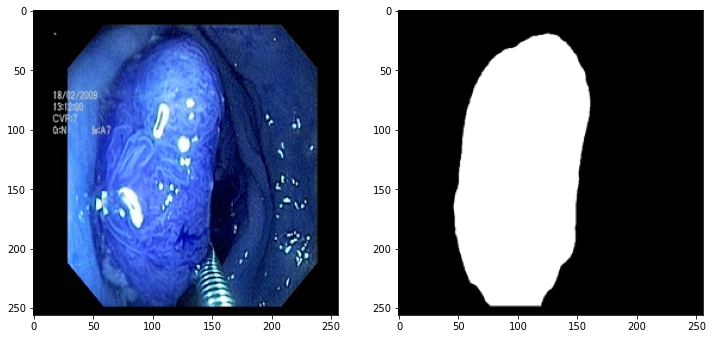

In [24]:

#Sanity check
import random
import numpy as np
image_number = random.randint(0, len(test_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(test_image_dataset[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(test_mask_dataset[image_number], (256, 256)), cmap='gray')
plt.show()

2be5f915-d8fa-47d6-8cc2-c104d05bbe18.jpg


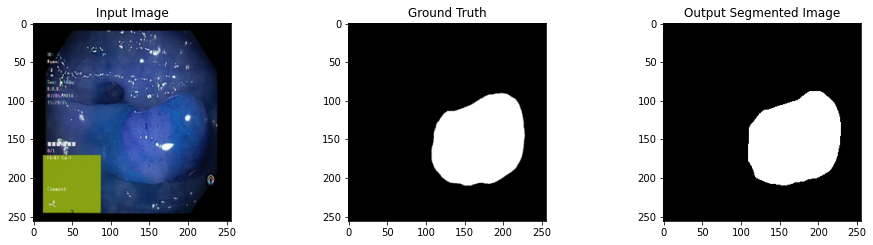

iou=  0.96660674
dice=  0.9759379
accuracy=  0.98706055
precision: 0.9835893
recall: 0.9715673
f1 0.9775413274765015


In [26]:

import random
test_img_number = random.randint(0, test_image_dataset.shape[0]-1)
print(filenames[test_img_number])
test_img = test_image_dataset[test_img_number]
ground_truth=test_mask_dataset[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Input Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Output Segmented Image')
plt.imshow(prediction, cmap='gray')
plt.show()


from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
iou = IOU_keras.result().numpy()

y_true = ground_truth
y_pred = prediction

m = tf.keras.metrics.Precision()
m.update_state(y_true, y_pred)
precision = m.result().numpy()

m2 = tf.keras.metrics.Recall()
m2.update_state(y_true, y_pred)
recall = m2.result().numpy()

m3 = tf.keras.metrics.Accuracy()
m3.update_state(y_true, y_pred)
accuracy = m3.result().numpy()

f1= 2*((precision*recall)/(precision+recall))


ground_truth = ground_truth.astype('float32')
prediction = prediction.astype('float32')
dice=dice_coef(ground_truth, prediction).numpy()

print("iou= ", iou)
print("dice= ",dice)
print("accuracy= ",accuracy)
print('precision:',precision)
print('recall:', recall)
print('f1', f1)


In [28]:

import pandas as pd

IoU_values = []
dice_values = []
precision_values = []
recall_values = []
f1_values = []
accuracy_values = []

for img in range(0, test_image_dataset.shape[0]):
    temp_img = test_image_dataset[img]
    ground_truth=test_mask_dataset[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    print(filenames[img])

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Input Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Ground Truth')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Output Segmented Image')
    plt.imshow(prediction, cmap='gray')
    plt.savefig('/content/drive/MyDrive/Segmented/{}'.format(filenames[img]), bbox_inches="tight", pad_inches=0.5)
    plt.show()
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    ground_truth1 = ground_truth.astype('float32')
    prediction1 = prediction.astype('float32')
    dice = dice_coef(ground_truth1, prediction1).numpy()
    dice_values.append(dice)


    y_true = ground_truth
    y_pred = prediction

    m = tf.keras.metrics.Precision()
    m.update_state(y_true, y_pred)
    precision = m.result().numpy()
    precision_values.append(precision)

    m2 = tf.keras.metrics.Recall()
    m2.update_state(y_true, y_pred)
    recall = m2.result().numpy()
    recall_values.append(recall)

    m3 = tf.keras.metrics.Accuracy()
    m3.update_state(y_true, y_pred)
    accuracy = m3.result().numpy()
    accuracy_values.append(accuracy)

    f1= 2*((precision*recall)/(precision+recall))
    f1_values.append(f1)

   

    print("iou= ", IoU)
    print("dice= ",dice)
    print("accuracy= ",accuracy)
    print('precision:',precision)
    print('recall:', recall)
    print('f1', f1)


with open('/content/drive/MyDrive/dicelistd52.txt', 'w') as fp: 
    for item in dice_values:
      fp.write("%s\n" % item)
    print('Done dice txt')

with open('/content/drive/MyDrive/accuracylistd52.txt', 'w') as fp2: 
    for item in accuracy_values:
      fp2.write("%s\n" % item)
    print('Done accuracy txt')

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values

df2 = pd.DataFrame(dice_values, columns=["dice"])
df2 = df2[df2.dice != 1.0]    
mean_dice = df2.mean().values

df3 = pd.DataFrame(accuracy_values, columns=["accuracy"])
df3 = df3[df3.accuracy != 1.0]    
mean_accuracy = df3.mean().values

df4 = pd.DataFrame(precision_values, columns=["precision"])
df4 = df4[df4.precision != 1.0]    
mean_precision = df4.mean().values

df5 = pd.DataFrame(recall_values, columns=["recall"])
df5 = df5[df5.recall != 1.0]    
mean_recall = df5.mean().values

df6 = pd.DataFrame(f1_values, columns=["f1"])
df6 = df6[df6.f1 != 1.0]    
mean_f1 = df6.mean().values

print("Mean IoU on unseen is: ", mean_IoU)    
print("Mean dice on unseen is: ", mean_dice)  
print("Mean accuracy on unseen is: ", mean_accuracy)  
print("Mean precision on unseen is: ", mean_precision)    
print("Mean recall on unseen is: ", mean_recall)  
print("Mean f1 on unseen  is: ", mean_f1) 

Output hidden; open in https://colab.research.google.com to view.